In [1]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
def ensamble_T(R_w_c, t_w_c) -> np.array:
    """
    Ensamble the a SE(3) matrix with the rotation matrix and translation vector.
    """
    T_w_c = np.zeros((4, 4), dtype=np.float32)
    T_w_c[0:3, 0:3] = R_w_c
    T_w_c[0:3, 3] = t_w_c
    T_w_c[3, 3] = 1
    return T_w_c

In [3]:
def Amatrix(x1, x2, P1, P2):
    A1 = [P1[2, :]*x1[0] - P1[0, :]*x1[2]]
    A2 = [P1[2, :]*x1[1] - P1[1, :]*x1[2]]
    A3 = [P2[2, :]*x2[0] - P2[0, :]*x2[2]]
    A4 = [P2[2, :]*x2[1] - P2[1, :]*x2[2]]
    A = np.vstack([A1, A2, A3, A4])
    return A

In [4]:
#First we read all the data
T_w_c1 = np.loadtxt('T_w_c1.txt')
T_w_c2 = np.loadtxt('T_w_c2.txt')
K_c = np.loadtxt('K_c.txt')
X_w = np.loadtxt('X_w.txt')
F_21_test=np.loadtxt('F_21_test.txt')

x1 = np.loadtxt('x1Data.txt')
x2 = np.loadtxt('x2Data.txt')

I = [[1., 0., 0., 0.], [0., 1., 0., 0.], [0., 0., 1., 0.]]


In [5]:
#1. POINT TRIANGULATION

#Proyection matrices
P1 = K_c @ I @ np.linalg.inv(T_w_c1)
P2 = K_c @ I @ np.linalg.inv(T_w_c2)

#Now we are going to get the 3D coordinates
x1_comp = np.vstack([x1, np.ones((1, 103))])
x2_comp = np.vstack([x2, np.ones((1, 103))])
Apoints = []
for i in range (0,103):
    MatrixA = Amatrix(x1_comp[:,i], x2_comp[:,i], P1, P2)
    U, S, Vt = np.linalg.svd(MatrixA)
    Vt = Vt[3, :] / Vt[3,3]
    Apoints.append(np.transpose(Vt))

#In Apoints are the 3D coordinates
Apoints = np.array(Apoints).T



In [6]:
def plotNumberedImagePoints(x,strColor,offset):
    """
        Plot indexes of points on a 2D image.
         -input:
             x: Points coordinates.
             strColor: Color of the text.
             offset: Offset from the point to the text.
         -output: None
         """
    for k in range(x.shape[1]):
        plt.text(x[0, k]+offset[0], x[1, k]+offset[1], str(k), color=strColor)


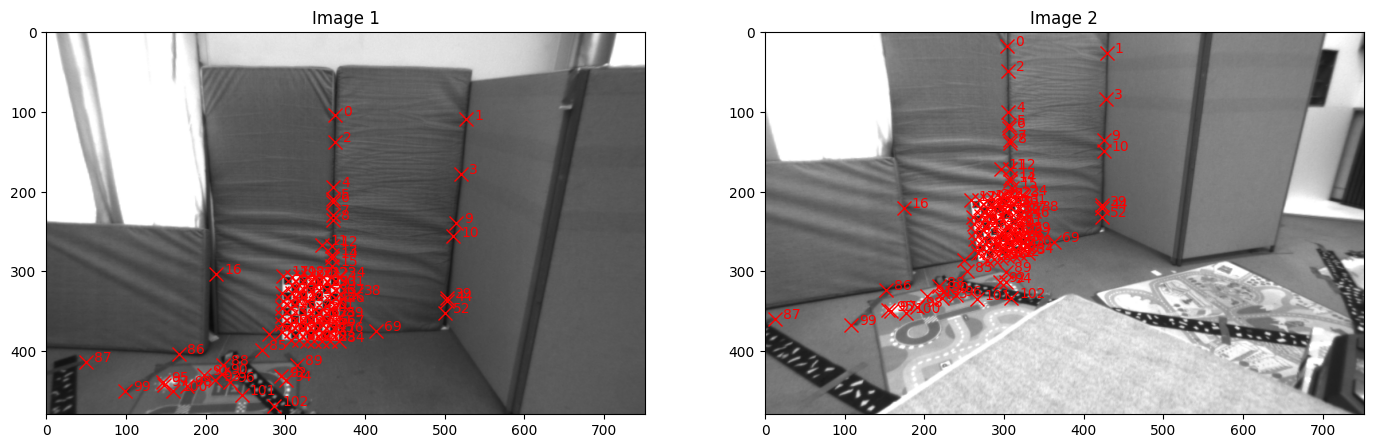

In [7]:
#Now we wnat to see the matching point in each image
img1 = cv2.cvtColor(cv2.imread('image1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('image2.png'), cv2.COLOR_BGR2RGB)

plt.figure(figsize =(17,7))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.plot(x1[0, :], x1[1, :],'rx', markersize=10)
plotNumberedImagePoints(x1, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.plot(x2[0, :], x2[1, :],'rx', markersize=10)
plotNumberedImagePoints(x2, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 2')
plt.draw()



In [8]:
def drawRefSystem(ax, T_w_c, strStyle, nameStr):
    """
        Draw a reference system in a 3D plot: Red for X axis, Green for Y axis, and Blue for Z axis
    -input:
        ax: axis handle
        T_w_c: (4x4 matrix) Reference system C seen from W.
        strStyle: lines style.
        nameStr: Name of the reference system.
    """
    draw3DLine(ax, T_w_c[0:3, 3:4], T_w_c[0:3, 3:4] + T_w_c[0:3, 0:1], strStyle, 'r', 1)
    draw3DLine(ax, T_w_c[0:3, 3:4], T_w_c[0:3, 3:4] + T_w_c[0:3, 1:2], strStyle, 'g', 1)
    draw3DLine(ax, T_w_c[0:3, 3:4], T_w_c[0:3, 3:4] + T_w_c[0:3, 2:3], strStyle, 'b', 1)
    ax.text(np.squeeze( T_w_c[0, 3]+0.1), np.squeeze( T_w_c[1, 3]+0.1), np.squeeze( T_w_c[2, 3]+0.1), nameStr)
    
def draw3DLine(ax, xIni, xEnd, strStyle, lColor, lWidth):
    """
    Draw a segment in a 3D plot
    -input:
        ax: axis handle
        xIni: Initial 3D point.
        xEnd: Final 3D point.
        strStyle: Line style.
        lColor: Line color.
        lWidth: Line width.
    """
    ax.plot([np.squeeze(xIni[0]), np.squeeze(xEnd[0])], [np.squeeze(xIni[1]), np.squeeze(xEnd[1])], [np.squeeze(xIni[2]), np.squeeze(xEnd[2])],
            strStyle, color=lColor, linewidth=lWidth)
    
def plotNumbered3DPoints(ax, X,strColor, offset):
    """
        Plot indexes of points on a 3D plot.
         -input:
             ax: axis handle
             X: Points coordinates.
             strColor: Color of the text.
             offset: Offset from the point to the text.
         -output: None
         """
    for k in range(X.shape[1]):
        ax.text(X[0, k]+offset[0], X[1, k]+offset[1], X[2,k]+offset[2], str(k), color=strColor)

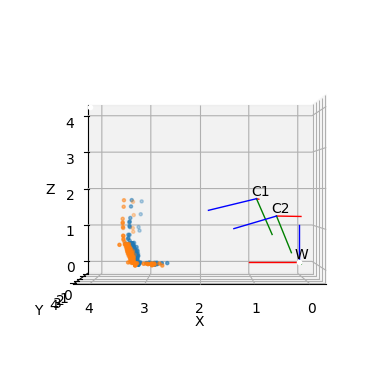

In [11]:
##Plot the 3D cameras and the 3D points
fig3D = plt.figure(3)

ax = plt.axes(projection='3d', adjustable='box')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

drawRefSystem(ax, np.eye(4, 4), '-', 'W')
drawRefSystem(ax, T_w_c1, '-', 'C1')
drawRefSystem(ax, T_w_c2, '-', 'C2')

ax.scatter(Apoints[0, :], Apoints[1, :], Apoints[2, :], marker='.')
#plotNumbered3DPoints(ax, Apoints, 'r', (0.1, 0.1, 0.1)) # For plotting with numbers (choose one of the both options)

#Matplotlib does not correctly manage the axis('equal')
xFakeBoundingBox = np.linspace(0, 4, 2)
yFakeBoundingBox = np.linspace(0, 4, 2)
zFakeBoundingBox = np.linspace(0, 4, 2)
ax.scatter(X_w[0, :], X_w[1, :], X_w[2, :], marker='.')

plt.plot(xFakeBoundingBox, yFakeBoundingBox, zFakeBoundingBox, 'w.')

ax.view_init(elev=90, azim=0)#Plane XY

ax.view_init(elev=0, azim=0)#Plane XZ

ax.view_init(elev=0, azim=90)#Plane YZ


In [12]:
import cv2

coordenadas = None

def obtener_coordenadas(event, x, y, flags, param):
    global coordenadas
    if event == cv2.EVENT_LBUTTONDOWN:
        coordenadas = (x, y)
        cv2.setMouseCallback("Imagen", lambda *args: None)
        cv2.destroyAllWindows()

def obtener_punto_en_imagen(imagen):
    global coordenadas
    coordenadas = None
    
    if imagen is None:
        raise Exception(f"No se pudo cargar la imagen: {imagen_path}")

    cv2.imshow("Imagen", imagen)
    cv2.setMouseCallback("Imagen", obtener_coordenadas)

    while True:
        if coordenadas is not None:
            break
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cv2.destroyAllWindows()

    return coordenadas


In [13]:
def visualize_epipolar_line(F, image1, image2):
    punto = obtener_punto_en_imagen(image1)
    x1, y1 = punto
    # Create a point in homogeneous coordinates (x, y, 1)
    point_in_image1 = np.array([x1, y1, 1])
    # Compute the epipolar line in image 2 using F and the clicked point in image 1
    epipolar_line_in_image2 = np.dot(F, point_in_image1)
    # Extract coefficients of the epipolar line (ax + by + c = 0)
    a, b, c = epipolar_line_in_image2
    # Calculate two points on the epipolar line in image 2
    x2_1 = 0
    y2_1 = int((-c - a * x2_1) / b)
    x2_2 = image2.shape[1] - 1
    y2_2 = int((-c - a * x2_2) / b)
    # Draw the epipolar line on image 2
    image2_with_line = cv2.line(image2, (x2_1, y2_1), (x2_2, y2_2), (0, 255, 0), 2)
    # Image 1
    plt.figure(1)
    plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
    plt.plot(x1, y1, marker="o", markersize=2, markeredgecolor='r')
    plt.title('Image 2 with Epipolar Line')
    plt.axis('off')
    plt.show()
    plt.clf() 
    plt.close(1)
    # Image 2
    plt.figure(2)
    plt.imshow(cv2.cvtColor(image2_with_line, cv2.COLOR_BGR2RGB))
    plt.title('Image 2 with Epipolar Line')
    plt.axis('off')
    plt.show()
    plt.clf() 
    plt.close(2) 

    
# Example usage:
image1 = cv2.imread("image1.png")
image2 = cv2.imread("image2.png")
visualize_epipolar_line(F_21_test, image1, image2)

visualize_epipolar_line(F_21_test, image1, image2)

visualize_epipolar_line(F_21_test, image1, image2)


KeyboardInterrupt: 

In [14]:
#2. FUNDAMENTAL MATRIX AND STRUCTURE FROM MOTION
    
#2.1 epipolar lines visualization
image1 = cv2.imread("image1.png")
image2 = cv2.imread("image2.png")
F_21 = np.loadtxt('F_21_test.txt')


#With this function we get the epipolar lines and draw it in the figure
visualize_epipolar_line(F_21_test, image1, image2)

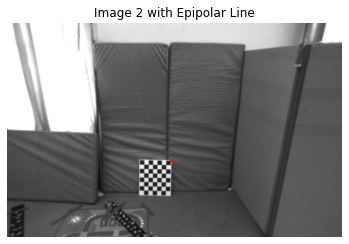

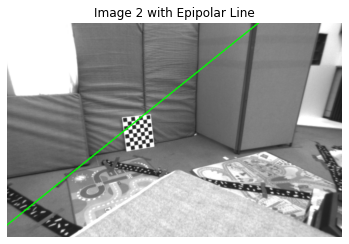

<Figure size 432x288 with 0 Axes>

In [ ]:
#2.2 Fundamental matrix from T_w_c1 and T_w_c2
T_c2_c1 = np.linalg.inv(T_w_c2) @ T_w_c1

R = T_c2_c1[0:3, 0:3]
t = T_c2_c1[0:3, 3]

#This is the fundamental matrix
E = [[0, -t[2], t[1]], [t[2], 0, -t[0]], [-t[1], t[0], 0]] @ R

F = np.linalg.inv(K_c).T @ E @ np.linalg.inv(K_c)

image1 = cv2.imread("image1.png")
image2 = cv2.imread("image2.png")
visualize_epipolar_line(F, image1, image2)
#For the epipolar we should just use the function 'get_epipolar_lines'



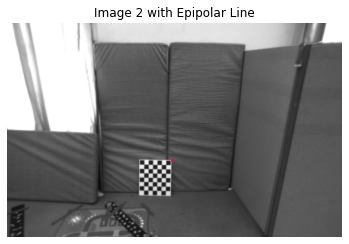

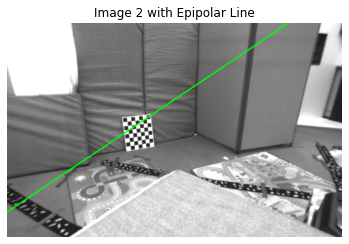

<Figure size 432x288 with 0 Axes>

In [ ]:
#2.3 Fndamental matrix linear estimation with eight point solution

x1,y1 = np.loadtxt('x1Data.txt')
x2,y2 = np.loadtxt('x2Data.txt')
A = np.zeros((len(x1), 9))
for i in range(len(x1)):
    A[i] = [x1[i] * x2[i], y1[i] * x2[i], x2[i], x1[i] * y2[i], y1[i] * y2[i], y2[i], x1[i], y1[i], 1]
# Solve for the singular value decomposition of A
_, _, V = np.linalg.svd(A)

# Extract the fundamental matrix from the last column of V
Faaa = V[-1].reshape(3, 3)

# Enforce the rank-2 constraint on F by performing SVD and zeroing out the smallest singular value
U, S, Vt = np.linalg.svd(Faaa)
S[-1] = 0
Faaa = np.dot(U, np.dot(np.diag(S), Vt))

# Estimate the Fundamental Matrix using the eight-point algorithm
#F_estimated = eight_point_algorithm(x1, x2)
#F_estimated

image1 = cv2.imread("image1.png")
image2 = cv2.imread("image2.png")
visualize_epipolar_line(Faaa, image1, image2)

In [ ]:
#2.4
E_21 = K_c.T @ F_21_test @ K_c
print(E)

# Perform SVD on the essential matrix E_21
U, _, Vt = np.linalg.svd(E_21)

# Ensure that the determinant of U and Vt is positive (to ensure proper rotation)
if np.linalg.det(U) < 0:
    U *= -1
if np.linalg.det(Vt) < 0:
    Vt *= -1
    
# Create the rotation matrices
W = np.array([[0, -1, 0],
              [1, 0, 0],
              [0, 0, 1]])
R1 = np.dot(U, np.dot(W, Vt))
R2 = np.dot(U, np.dot(W.T, Vt))

# Create the translation vectors
t1 = U[:, 2]
t2 = -U[:, 2]

# Form the four possible camera transformation matrices T_21
T_21_1 = np.hstack((R1, t1.reshape(-1, 1)))
T_21_2 = np.hstack((R1, t2.reshape(-1, 1)))
T_21_3 = np.hstack((R2, t1.reshape(-1, 1)))
T_21_4 = np.hstack((R2, t2.reshape(-1, 1)))

In [27]:
#2.5 
U, S, Vt = np.linalg.svd(E)

# Perform SVD on the essential matrix E
U, _, Vt = np.linalg.svd(E)

# Ensure that the determinant of U and Vt is positive (to ensure proper rotation)
if np.linalg.det(U) < 0:
    U *= -1
if np.linalg.det(Vt) < 0:
    Vt *= -1
    
# Create the rotation matrices
W = np.array([[0, -1, 0],
              [1, 0, 0],
              [0, 0, 1]])
R1 = np.dot(U, np.dot(W, Vt))
R2 = np.dot(U, np.dot(W.T, Vt))

# Create the translation vectors
t1 = U[:, 2]
t2 = -U[:, 2]

# Form the four possible camera transformation matrices T_21
T_21_1 = np.hstack((R1, t1.reshape(-1, 1)))
T_21_2 = np.hstack((R1, t2.reshape(-1, 1)))
T_21_3 = np.hstack((R2, t1.reshape(-1, 1)))
T_21_4 = np.hstack((R2, t2.reshape(-1, 1)))

In [41]:
#3 HOMOGRAPHIES
import numpy as np

# Provided pose for camera reference 1


T_c2_c1 = np.linalg.inv(T_w_c2) @ T_w_c1
R_c2_c1 = T_c2_c1[0:3, 0:3]
t_c2_c1 = T_c2_c1[0:3, 3:4]

#Pi_1 = np.loadtxt('Pi_1.txt')

Pi_1 = np.array([[0.0149, 0.9483, 0.3171, -1.7257]])

#t_c2_c1 = np.reshape(t_c2_c1,(3))
A = (t_c2_c1 @ Pi_1[:,0:3]) / Pi_1[0,3]
print(A.shape)
print(Pi_1[:,0:3])
H=K_c @ (R_c2_c1-t_c2_c1 @ Pi_1[:,0:3] / Pi_1[0,3]) @ np.linalg.inv(K_c)


print(A)

(3, 3)
[[0.0149 0.9483 0.3171]]
[[-0.00636285 -0.40495888 -0.13541333]
 [ 0.00626555  0.39876626  0.13334259]
 [-0.00565225 -0.35973341 -0.12029048]]


In [42]:
#Now we are going to get the 3D coordinates
x1floor = np.loadtxt('x1FloorData.txt')
x2floor = np.loadtxt('x2FloorData.txt')
x1floor = x1floor/x1floor[2,:]

x1_new = H@x1floor

x1_new= x1_new/x1_new[2,:]
x2floor


array([[363., 312., 330., 302., 223., 203., 295., 222., 303., 240., 191.,
        108., 177., 266.],
       [263., 280., 277., 301., 326., 331., 313., 333., 314., 330., 345.,
        367., 352., 335.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.]])

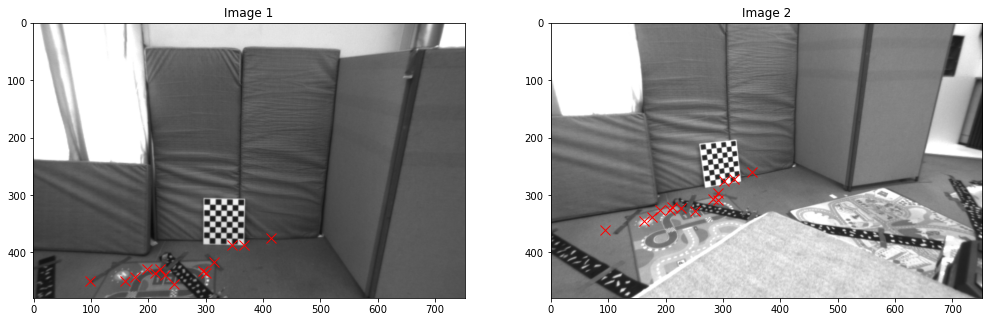

In [43]:
img1 = cv2.cvtColor(cv2.imread('image1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('image2.png'), cv2.COLOR_BGR2RGB)

plt.figure(figsize =(17,7))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.plot(x1floor[0, :], x1floor[1, :],'rx', markersize=10)
#plotNumberedImagePoints(x1, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.plot(x1_new[0, :], x1_new[1,:],'rx', markersize=10)
#plotNumberedImagePoints(x2, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 2')
plt.draw()

In [37]:
def homography(x0,x1):
    matriz=np.zeros((2*x1.shape[1],9),dtype=np.float64)
    for i in range(x1.shape[1]):
        matriz[2*i,0]=x0[0,i]
        matriz[2*i,1]=x0[1,i]
        matriz[2*i,2]=1
        matriz[2*i,6]=-x0[0,i]*x1[0,i]
        matriz[2*i,7]=-x0[1,i]*x1[0,i]
        matriz[2*i,8]=-x1[0,i]
        matriz[2*i+1,3]=x0[0,i]
        matriz[2*i+1,4]=x0[1,i]
        matriz[2*i+1,5]=1
        matriz[2*i+1,6]=-x0[0,i]*x1[1,i]
        matriz[2*i+1,7]=-x0[1,i]*x1[1,i]
        matriz[2*i+1,8]=-x1[1,i]
    print(matriz.shape)
    _ , _, v = np.linalg.svd(matriz)
    v=v.T
    v=v[:,8]
    v=v.reshape((3,3))
    return v

def homography1(x0, x1):
    N = x0.shape[1]  # Assuming x0 and x1 are 3xN arrays

    A = np.zeros((2 * N, 9))
    for i in range(0, N):
        x1_dat, y1, z1 = x0[:, i]
        x2, y2, z2 = x1[:, i]
        A[2 * i] = [-x1_dat, -y1, -1, 0, 0, 0, x1_dat * x2, x2 * y1, x2]
        A[2 * i + 1] = [0, 0, 0, -x1_dat, -y1, -1, y1 * x2, y2 * x1_dat, y2]
    _ , _, v = np.linalg.svd(A)
    v=v.T
    v=v[:,8]
    v=v.reshape((3,3))
    return v

In [38]:

x1floor = np.loadtxt('x1FloorData.txt')
x2floor = np.loadtxt('x2FloorData.txt')


x1floor = x1floor/x1floor[2,:]
x2floor = x2floor/x2floor[2,:]

homography=homography1(x1floor,x2floor) #We calculate the homography matrix
print(homography)

#to evaluate the accuracy of our results we calculate the distance between the real point
#in the second picture and the one we obtain multiplying the homography matrix by
#the point in the first picture

x2_homography = homography@x1floor#we obtain the point in the second picture

x2_homography=x2_homography/x2_homography[2,:]

x2_homography

[[ 3.29904134e-03  2.14571464e-03 -9.90914496e-01]
 [ 3.34299082e-04  2.41845813e-03 -1.34391969e-01]
 [ 1.75774544e-06  3.29211511e-07  2.41068798e-03]]


array([[361.61442266, 311.7801443 , 330.56890945, 303.15400881,
        224.01352674, 201.68827665, 296.03402835, 220.74356782,
        304.76185096, 239.84975507, 189.24362891, 110.23736717,
        175.88066173, 265.33505048],
       [279.26788595, 291.52552237, 291.08003501, 315.84070067,
        332.27208044, 335.04882211, 328.51021996, 339.35063701,
        331.78321273, 339.31482238, 348.27741742, 361.16501558,
        354.81187062, 350.3394563 ],
       [  1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ,   1.        ,   1.        ,
          1.        ,   1.        ]])

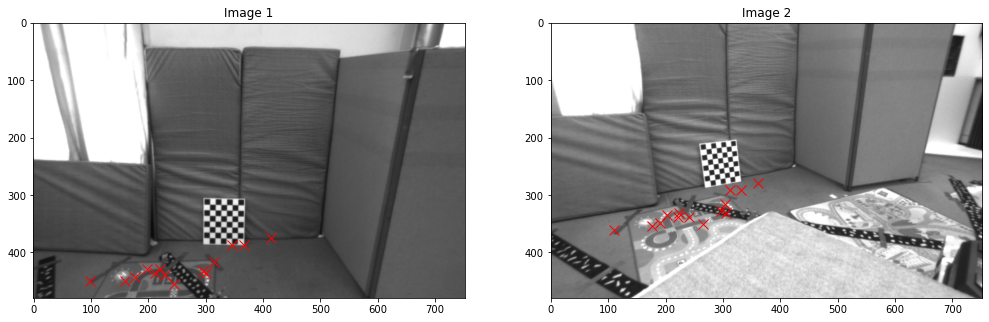

In [39]:
img1 = cv2.cvtColor(cv2.imread('image1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('image2.png'), cv2.COLOR_BGR2RGB)

plt.figure(figsize =(17,7))
plt.subplot(1,2,1)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.plot(x1floor[0, :], x1floor[1, :],'rx', markersize=10)
#plotNumberedImagePoints(x1, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 1')

plt.subplot(1, 2, 2)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.plot(x2_homography[0, :], x2_homography[1,:],'rx', markersize=10)
#plotNumberedImagePoints(x2, 'r', (10,0)) # For plotting with numbers (choose one of the both options)
plt.title('Image 2')
plt.draw()